In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [3]:
print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.13.0
Found GPU at: /device:GPU:0


#컴퓨터비전에 쓰이는 ML모델

##이미지 데이터를 읽기

In [4]:
def read_and_decode(filename, reshape_dims):
  #파일 읽기
  img = tf.io.read_file(filename)

  #압축된 문자열을 3D uint8 텐서로 변환. 이미지 포맷을 디코딩해야 조회 테이블에서 픽셀값으로 찾을 수 있음.
  img = tf.image.decode_jpeg(img, channels=3) #여기에서 채널은 세 가지 색상 채널을 의미.

  #3D uint8을 [0,1]범위의 float으로 변환
  img = tf.image.convert_image_dtype(img, tf.float32)

  #이미지를 원하는 사이즈로 조정. 종횡비를 유지할 수 없는 방법임.
  return tf.image.resize(img, reshape_dims)


##이미지 데이터를 시각화

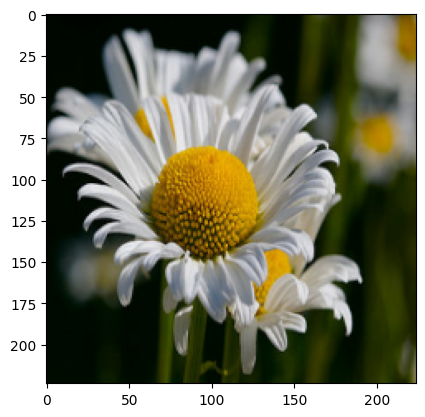

In [25]:
def show_image(filename):
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  plt.imshow(img.numpy())

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3
show_image("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/754296579_30a9ae018c_n.jpg")

gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/100930342_92e8746431_n.jpg
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/10094729603_eeca3f2cb6.jpg
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/10094731133_94a942463c.jpg
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/10128546863_8de70c610d.jpg
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/10163955604_ae0b830975_n.jpg


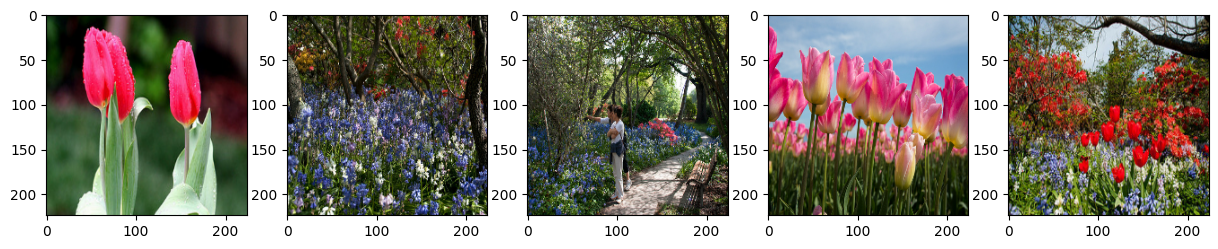

In [6]:
tulips = tf.io.gfile.glob("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/*.jpg")
f, (ax) = plt.subplots(1, 5, figsize=(15,15))
for idx, filename in enumerate(tulips[0:5]):
  print(filename)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  ax[idx].imshow(img.numpy())

##데이터셋 파일 읽기

In [21]:
def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  return img, label

dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").
    map(decode_csv))

for img, label in dataset.take(3):
  avg = tf.math.reduce_mean(img, axis=[0, 1]) #전체 열과 전체 행의 평균을 계산. 채널 수가 3이라서 출력도 길이가 3인 1차원 텐서임.
  print(label, avg)

CLASS_NAMES = [item.numpy().decode("utf-8") for item in
               tf.strings.regex_replace(
                 tf.io.gfile.glob("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/*"),
                 "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/", "")]
CLASS_NAMES = [item for item in CLASS_NAMES if item.find(".") == -1] #find 메서드는 인덱스 반환함. -1은 없다는 것.
print(CLASS_NAMES)

tf.Tensor(b'daisy', shape=(), dtype=string) tf.Tensor([0.3588961  0.36257887 0.26933077], shape=(3,), dtype=float32)
tf.Tensor(b'dandelion', shape=(), dtype=string) tf.Tensor([0.32278517 0.32278517 0.32278517], shape=(3,), dtype=float32)
tf.Tensor(b'dandelion', shape=(), dtype=string) tf.Tensor([0.20397592 0.13298093 0.07217225], shape=(3,), dtype=float32)
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


##케라스를 사용한 선형모델

In [22]:
#선형모델 구현

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)),
    tf.keras.layers.Dense(len(CLASS_NAMES)) #분류에서 마지막 layer 출력은 class 개수와 동일해야하기 때문.
])

In [23]:
#케라스 모델 훈련

model.compile(
    optimizer = 'adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [26]:
#예측 함수

batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS]) #이미지를 배치단위로 전달해야하나까 이미지 하나로 구성된 배치로 변환.
batch_pred = model.predict(batch_image)
pred = batch_pred[0] #첫 번째 이미지에 대한 accuracy.

pred_label_index = tf.math.argmax(pred) #가장 높은 accuracy를 가진 class 찾아내는 것
pred_label = CLASS_NAMES[pred_label_index]

#pred의 값을 softmax 함수를 사용하여 확률로 변환할 수 있다.
prob = tf.math.softmax(pred)
prob = prob[pred_label_index] #예측된 yhat의 확률을 알 수 있음.

1/1 [==============================] - 5s 5s/step


##활성화 함수

In [27]:
#활성화 함수를 pred 값에 따로 적용하지 않고, 모델의 마지막 레이어에 추가할 수 있다.

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    tf.keras.layers.Dense(len(CLASS_NAMES), activation = 'softmax')
])

##배치(Batch)

In [28]:
train_dataset = (tf.data.TextLineDataset(
    "gs://cloud-ml-data/img/flower_photos/train_set.csv").map(decode_csv)
).batch(10) #배치당 10개의 데이터

##훈련 손실

In [30]:
#옵티마이저가 손실을 계산하기 위해서는 decode_csv 함수에서 반환한 라벨과 model.predict()의 출력이 함께 필요함.

#One Hot Encoding Ver.
def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  label = tf.math.equal(CLASS_NAMES, label_string) #class names와 label의 스트링을 비교하여 boolean value로 원핫 인코딩된 배열을 반환.
  return img, label

tf.keras.losses.CategoricalCrossentropy(from_logits=False) #OHE일 때는 교차 엔트로피 사용.


In [32]:
#Sparse Representation Ver.
def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string)) #class names와 label의 스트링을 비교하여 boolean value로 원핫 인코딩된 배열을 반환. 올바른 클래스의 위치 반환
  return img, label

tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

#모델 훈련 실습

## 데이터셋 만들기

In [42]:
def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  return img, label

train_dataset = (
    tf.data.TextLineDataset(
        "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv"
    ).map(decode_csv)
).batch(10) #배치당 10개의 이미지

eval_dataset = (
    tf.data.TextLineDataset(
        "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv"
    ).map(decode_csv)
).batch(10)

## 모델 생성 및 보기

In [43]:
#모델 생성
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)),
    tf.keras.layers.Dense(len(CLASS_NAMES), activation = 'softmax')
])

model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

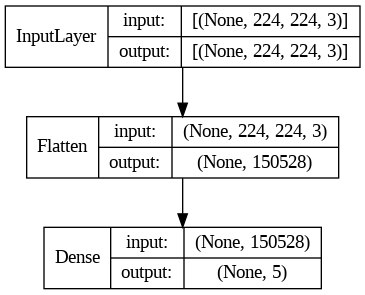

In [44]:
#모델 시각화
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

In [45]:
#모델 피팅

history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)

Epoch 1/10
330/330 [==============================] - 130s 392ms/step - loss: 15.6703 - accuracy: 0.3482 - val_loss: 11.7761 - val_accuracy: 0.3865
Epoch 2/10
330/330 [==============================] - 126s 381ms/step - loss: 13.6771 - accuracy: 0.4215 - val_loss: 11.6520 - val_accuracy: 0.4351
Epoch 3/10
330/330 [==============================] - 121s 368ms/step - loss: 15.4963 - accuracy: 0.4379 - val_loss: 18.0291 - val_accuracy: 0.4622
Epoch 4/10
330/330 [==============================] - 114s 346ms/step - loss: 13.2446 - accuracy: 0.4879 - val_loss: 12.7519 - val_accuracy: 0.4243
Epoch 5/10
330/330 [==============================] - 110s 333ms/step - loss: 13.6125 - accuracy: 0.4997 - val_loss: 20.6559 - val_accuracy: 0.4216
Epoch 6/10
330/330 [==============================] - 101s 305ms/step - loss: 15.8942 - accuracy: 0.5067 - val_loss: 31.2160 - val_accuracy: 0.4000
Epoch 7/10
330/330 [==============================] - 106s 320ms/step - loss: 14.1626 - accuracy: 0.5270 - val_l

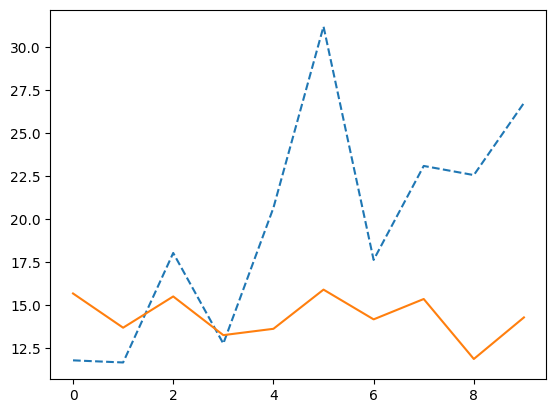

In [47]:
plt.plot(history.history['val_loss'], ls = 'dashed')
plt.plot(history.history['loss'])

In [48]:
# 예측 결과 출력

batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
batch_pred = model.predict(batch_image)
pred = batch_pred[0]

1/1 [==============================] - 0s 231ms/step


In [49]:
print(pred)

[7.8898097e-09 1.0000000e+00 2.7722127e-11 5.3306132e-10 3.4037473e-14]
